In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch import DeepLabV3

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV4(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=1,
        )

        self.cloud_phase_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cod_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )
        self.cps_net = DeepLabV3(
            encoder_name='resnet34',
            in_channels=64,
            classes=15,
        )

        self.conv0 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=16, out_channels=5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)


    def forward(self, x):
        x = F.relu(self.conv0(x))
        cloud_mask_pred = self.cloud_mask_net(x)
        cloud_phase_pred = self.cloud_phase_net(x)
        cod_pred = self.cod_net(x)
        cps_pred = self.cps_net(x)

        cloud_phase_pred = torch.cat([cloud_mask_pred, cloud_phase_pred], dim=1)
        cod_pred = torch.cat([cloud_mask_pred, cod_pred], dim=1)
        cps_pred = torch.cat([cloud_mask_pred, cps_pred], dim=1)

        cloud_phase_pred = F.relu(self.conv1(cloud_phase_pred))
        cod_pred = F.relu(self.conv2(cod_pred))
        cps_pred = F.relu(self.conv3(cps_pred))

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV4().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")


100%|██████████| 94/94 [00:36<00:00,  2.59it/s]


Epoch: 1 | Train Loss: 4.1618 | Val Loss: 4.0035 | Val Mask: 0.7179 | Val Phase: 0.5761 | Val Cod: -0.0860 | Val Cps: -0.5522


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 2 | Train Loss: 3.4489 | Val Loss: 3.4719 | Val Mask: 0.8615 | Val Phase: 0.6046 | Val Cod: -0.2396 | Val Cps: -0.3454


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 3 | Train Loss: 3.1043 | Val Loss: 3.7452 | Val Mask: 0.8439 | Val Phase: 0.6535 | Val Cod: 0.0478 | Val Cps: -0.7196


100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Epoch: 4 | Train Loss: 2.8142 | Val Loss: 4.3720 | Val Mask: 0.8371 | Val Phase: 0.5607 | Val Cod: -1.6528 | Val Cps: -0.5708


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 5 | Train Loss: 2.5666 | Val Loss: 2.6727 | Val Mask: 0.8944 | Val Phase: 0.7119 | Val Cod: 0.0639 | Val Cps: -0.0596


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 6 | Train Loss: 2.3667 | Val Loss: 3.1771 | Val Mask: 0.8796 | Val Phase: 0.6439 | Val Cod: -0.1418 | Val Cps: -0.2476


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 7 | Train Loss: 2.1906 | Val Loss: 2.3673 | Val Mask: 0.8835 | Val Phase: 0.7372 | Val Cod: 0.1267 | Val Cps: 0.1957


100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Epoch: 8 | Train Loss: 2.0448 | Val Loss: 2.8090 | Val Mask: 0.8857 | Val Phase: 0.7374 | Val Cod: 0.1318 | Val Cps: -0.2803


100%|██████████| 94/94 [00:31<00:00,  2.95it/s]


Epoch: 9 | Train Loss: 1.9352 | Val Loss: 2.8624 | Val Mask: 0.8229 | Val Phase: 0.6617 | Val Cod: -0.3186 | Val Cps: 0.2435


100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch: 10 | Train Loss: 1.8330 | Val Loss: 5.0141 | Val Mask: 0.8599 | Val Phase: 0.3140 | Val Cod: -0.3134 | Val Cps: -0.2881


100%|██████████| 94/94 [00:31<00:00,  2.97it/s]


Epoch: 11 | Train Loss: 1.7583 | Val Loss: 3.8049 | Val Mask: 0.8007 | Val Phase: 0.3502 | Val Cod: -0.0802 | Val Cps: 0.0719


100%|██████████| 94/94 [00:31<00:00,  2.95it/s]


Epoch: 12 | Train Loss: 1.6749 | Val Loss: 2.7980 | Val Mask: 0.8263 | Val Phase: 0.7334 | Val Cod: -0.2373 | Val Cps: -0.0153


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 13 | Train Loss: 1.6051 | Val Loss: 2.1457 | Val Mask: 0.8915 | Val Phase: 0.7537 | Val Cod: 0.0786 | Val Cps: 0.2688


100%|██████████| 94/94 [00:31<00:00,  2.95it/s]


Epoch: 14 | Train Loss: 1.5454 | Val Loss: 2.1717 | Val Mask: 0.8580 | Val Phase: 0.7288 | Val Cod: 0.1557 | Val Cps: 0.3644


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 15 | Train Loss: 1.5081 | Val Loss: 2.2111 | Val Mask: 0.9137 | Val Phase: 0.7282 | Val Cod: 0.1556 | Val Cps: 0.3546


100%|██████████| 94/94 [00:33<00:00,  2.79it/s]


Epoch: 16 | Train Loss: 1.4771 | Val Loss: 2.4144 | Val Mask: 0.9063 | Val Phase: 0.6988 | Val Cod: 0.0870 | Val Cps: 0.3973


100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Epoch: 17 | Train Loss: 1.4574 | Val Loss: 2.1881 | Val Mask: 0.8653 | Val Phase: 0.7377 | Val Cod: -0.0620 | Val Cps: 0.3596


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 18 | Train Loss: 1.4283 | Val Loss: 2.2977 | Val Mask: 0.9232 | Val Phase: 0.7132 | Val Cod: 0.1335 | Val Cps: 0.3815


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 19 | Train Loss: 1.4136 | Val Loss: 2.3907 | Val Mask: 0.9066 | Val Phase: 0.7167 | Val Cod: 0.1583 | Val Cps: 0.1830


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 20 | Train Loss: 1.3935 | Val Loss: 2.7531 | Val Mask: 0.8931 | Val Phase: 0.4829 | Val Cod: 0.1575 | Val Cps: 0.4324


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 21 | Train Loss: 1.3786 | Val Loss: 3.3626 | Val Mask: 0.9265 | Val Phase: 0.4170 | Val Cod: 0.1697 | Val Cps: 0.3769


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 22 | Train Loss: 1.3608 | Val Loss: 2.4045 | Val Mask: 0.9051 | Val Phase: 0.7171 | Val Cod: -0.4029 | Val Cps: 0.4210


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 23 | Train Loss: 1.3476 | Val Loss: 2.3388 | Val Mask: 0.9086 | Val Phase: 0.5911 | Val Cod: 0.1287 | Val Cps: 0.3946


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 24 | Train Loss: 1.3372 | Val Loss: 2.1548 | Val Mask: 0.8269 | Val Phase: 0.7804 | Val Cod: 0.0898 | Val Cps: 0.3251


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 25 | Train Loss: 1.3227 | Val Loss: 2.0836 | Val Mask: 0.8594 | Val Phase: 0.7339 | Val Cod: 0.1487 | Val Cps: 0.3931


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 26 | Train Loss: 1.3223 | Val Loss: 2.2006 | Val Mask: 0.9070 | Val Phase: 0.7091 | Val Cod: 0.1626 | Val Cps: 0.4006


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 27 | Train Loss: 1.3100 | Val Loss: 2.2538 | Val Mask: 0.9237 | Val Phase: 0.6414 | Val Cod: 0.0295 | Val Cps: 0.4257


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 28 | Train Loss: 1.2982 | Val Loss: 2.0485 | Val Mask: 0.9048 | Val Phase: 0.7687 | Val Cod: 0.1956 | Val Cps: 0.3591


100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch: 29 | Train Loss: 1.2902 | Val Loss: 1.8812 | Val Mask: 0.9197 | Val Phase: 0.7742 | Val Cod: 0.1329 | Val Cps: 0.3862


100%|██████████| 94/94 [00:32<00:00,  2.91it/s]


Epoch: 30 | Train Loss: 1.2800 | Val Loss: 2.0953 | Val Mask: 0.9170 | Val Phase: 0.7821 | Val Cod: 0.1550 | Val Cps: 0.2539


100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch: 31 | Train Loss: 1.2675 | Val Loss: 1.7010 | Val Mask: 0.9245 | Val Phase: 0.8127 | Val Cod: 0.1446 | Val Cps: 0.4326


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 32 | Train Loss: 1.2645 | Val Loss: 1.9041 | Val Mask: 0.9333 | Val Phase: 0.7356 | Val Cod: 0.1392 | Val Cps: 0.3943


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 33 | Train Loss: 1.2535 | Val Loss: 1.9189 | Val Mask: 0.8912 | Val Phase: 0.7911 | Val Cod: 0.1437 | Val Cps: 0.3878


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch: 34 | Train Loss: 1.2442 | Val Loss: 1.9208 | Val Mask: 0.9215 | Val Phase: 0.8018 | Val Cod: 0.0704 | Val Cps: 0.2767


100%|██████████| 94/94 [00:29<00:00,  3.13it/s]


Epoch: 35 | Train Loss: 1.2400 | Val Loss: 2.1596 | Val Mask: 0.9043 | Val Phase: 0.7015 | Val Cod: 0.1763 | Val Cps: 0.3255


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 36 | Train Loss: 1.2358 | Val Loss: 2.9813 | Val Mask: 0.8995 | Val Phase: 0.4942 | Val Cod: 0.1953 | Val Cps: 0.3822


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 37 | Train Loss: 1.2224 | Val Loss: 1.8948 | Val Mask: 0.8950 | Val Phase: 0.7847 | Val Cod: 0.1112 | Val Cps: 0.4026


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 38 | Train Loss: 1.2169 | Val Loss: 2.0765 | Val Mask: 0.9256 | Val Phase: 0.6580 | Val Cod: 0.1680 | Val Cps: 0.4494


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 39 | Train Loss: 1.2079 | Val Loss: 1.7781 | Val Mask: 0.9275 | Val Phase: 0.8055 | Val Cod: 0.0872 | Val Cps: 0.3912


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 40 | Train Loss: 1.2077 | Val Loss: 2.3638 | Val Mask: 0.8667 | Val Phase: 0.6481 | Val Cod: 0.1756 | Val Cps: 0.3860


100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch: 41 | Train Loss: 1.2017 | Val Loss: 1.7515 | Val Mask: 0.9342 | Val Phase: 0.8096 | Val Cod: 0.1473 | Val Cps: 0.3455


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 42 | Train Loss: 1.1958 | Val Loss: 2.5164 | Val Mask: 0.9146 | Val Phase: 0.6103 | Val Cod: -0.0491 | Val Cps: 0.4302


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 43 | Train Loss: 1.1887 | Val Loss: 2.0165 | Val Mask: 0.8800 | Val Phase: 0.7462 | Val Cod: 0.1759 | Val Cps: 0.4114


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 44 | Train Loss: 1.1872 | Val Loss: 1.7260 | Val Mask: 0.9140 | Val Phase: 0.8017 | Val Cod: 0.2019 | Val Cps: 0.4100


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 45 | Train Loss: 1.1781 | Val Loss: 1.6677 | Val Mask: 0.9190 | Val Phase: 0.8205 | Val Cod: 0.1457 | Val Cps: 0.4351


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 46 | Train Loss: 1.1721 | Val Loss: 1.9086 | Val Mask: 0.9301 | Val Phase: 0.7776 | Val Cod: 0.1749 | Val Cps: 0.4060


100%|██████████| 94/94 [00:29<00:00,  3.18it/s]


Epoch: 47 | Train Loss: 1.1684 | Val Loss: 1.9218 | Val Mask: 0.9039 | Val Phase: 0.7765 | Val Cod: 0.1556 | Val Cps: 0.3935


100%|██████████| 94/94 [00:32<00:00,  2.89it/s]


Epoch: 48 | Train Loss: 1.1661 | Val Loss: 1.7361 | Val Mask: 0.9082 | Val Phase: 0.7918 | Val Cod: 0.2105 | Val Cps: 0.4568


100%|██████████| 94/94 [00:31<00:00,  2.99it/s]


Epoch: 49 | Train Loss: 1.1606 | Val Loss: 1.7488 | Val Mask: 0.9243 | Val Phase: 0.7743 | Val Cod: 0.1887 | Val Cps: 0.4494


100%|██████████| 94/94 [00:31<00:00,  3.03it/s]


Epoch: 50 | Train Loss: 1.1525 | Val Loss: 1.8062 | Val Mask: 0.9227 | Val Phase: 0.7972 | Val Cod: 0.1783 | Val Cps: 0.4158


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 51 | Train Loss: 1.1590 | Val Loss: 1.9306 | Val Mask: 0.8845 | Val Phase: 0.7894 | Val Cod: 0.1313 | Val Cps: 0.4328


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 52 | Train Loss: 1.1442 | Val Loss: 2.2584 | Val Mask: 0.9072 | Val Phase: 0.7181 | Val Cod: 0.1026 | Val Cps: 0.4284


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 53 | Train Loss: 1.1402 | Val Loss: 1.7622 | Val Mask: 0.9257 | Val Phase: 0.7867 | Val Cod: 0.1412 | Val Cps: 0.4371


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 54 | Train Loss: 1.1349 | Val Loss: 1.9825 | Val Mask: 0.8718 | Val Phase: 0.7502 | Val Cod: 0.1866 | Val Cps: 0.4284


100%|██████████| 94/94 [00:30<00:00,  3.08it/s]


Epoch: 55 | Train Loss: 1.1329 | Val Loss: 1.7709 | Val Mask: 0.9305 | Val Phase: 0.8036 | Val Cod: 0.1598 | Val Cps: 0.3926


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 56 | Train Loss: 1.1286 | Val Loss: 1.7631 | Val Mask: 0.9116 | Val Phase: 0.7843 | Val Cod: 0.1705 | Val Cps: 0.4416


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 57 | Train Loss: 1.1253 | Val Loss: 1.9468 | Val Mask: 0.8925 | Val Phase: 0.7809 | Val Cod: 0.1770 | Val Cps: 0.4442


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 58 | Train Loss: 1.1207 | Val Loss: 1.6944 | Val Mask: 0.9317 | Val Phase: 0.8063 | Val Cod: 0.1998 | Val Cps: 0.4206


100%|██████████| 94/94 [00:30<00:00,  3.07it/s]


Epoch: 59 | Train Loss: 1.1160 | Val Loss: 1.7463 | Val Mask: 0.9329 | Val Phase: 0.8055 | Val Cod: 0.2041 | Val Cps: 0.3741


100%|██████████| 94/94 [00:31<00:00,  3.03it/s]


Epoch: 60 | Train Loss: 1.1113 | Val Loss: 2.1704 | Val Mask: 0.9060 | Val Phase: 0.6778 | Val Cod: 0.1841 | Val Cps: 0.4163


100%|██████████| 94/94 [00:30<00:00,  3.06it/s]


Epoch: 61 | Train Loss: 1.1123 | Val Loss: 2.0181 | Val Mask: 0.9181 | Val Phase: 0.7791 | Val Cod: 0.1281 | Val Cps: 0.3615


100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Epoch: 62 | Train Loss: 1.1056 | Val Loss: 1.8541 | Val Mask: 0.9127 | Val Phase: 0.8081 | Val Cod: 0.2077 | Val Cps: 0.3494


100%|██████████| 94/94 [00:30<00:00,  3.09it/s]


Epoch: 63 | Train Loss: 1.1028 | Val Loss: 1.9622 | Val Mask: 0.9300 | Val Phase: 0.7630 | Val Cod: 0.1487 | Val Cps: 0.4558


100%|██████████| 94/94 [00:29<00:00,  3.16it/s]


Epoch: 64 | Train Loss: 1.1033 | Val Loss: 1.8648 | Val Mask: 0.9331 | Val Phase: 0.7905 | Val Cod: 0.0921 | Val Cps: 0.4227


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 65 | Train Loss: 1.0973 | Val Loss: 2.1464 | Val Mask: 0.9219 | Val Phase: 0.7715 | Val Cod: -0.1935 | Val Cps: 0.4433


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 66 | Train Loss: 1.0917 | Val Loss: 1.7490 | Val Mask: 0.9310 | Val Phase: 0.8011 | Val Cod: 0.1958 | Val Cps: 0.4341


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 67 | Train Loss: 1.0916 | Val Loss: 1.6984 | Val Mask: 0.9310 | Val Phase: 0.8075 | Val Cod: 0.1313 | Val Cps: 0.4217


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 68 | Train Loss: 1.0902 | Val Loss: 1.8624 | Val Mask: 0.9104 | Val Phase: 0.7633 | Val Cod: 0.1442 | Val Cps: 0.4101


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 69 | Train Loss: 1.0855 | Val Loss: 1.7274 | Val Mask: 0.9323 | Val Phase: 0.7852 | Val Cod: 0.1788 | Val Cps: 0.4384


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 70 | Train Loss: 1.0826 | Val Loss: 1.5934 | Val Mask: 0.9374 | Val Phase: 0.8168 | Val Cod: 0.2178 | Val Cps: 0.4430


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 71 | Train Loss: 1.0795 | Val Loss: 1.7386 | Val Mask: 0.9307 | Val Phase: 0.8063 | Val Cod: 0.1453 | Val Cps: 0.4182


100%|██████████| 94/94 [00:31<00:00,  2.94it/s]


Epoch: 72 | Train Loss: 1.0796 | Val Loss: 2.0791 | Val Mask: 0.9156 | Val Phase: 0.7503 | Val Cod: 0.2074 | Val Cps: 0.4476


100%|██████████| 94/94 [00:32<00:00,  2.91it/s]


Epoch: 73 | Train Loss: 1.0734 | Val Loss: 2.0126 | Val Mask: 0.9361 | Val Phase: 0.6836 | Val Cod: 0.2254 | Val Cps: 0.4629


100%|██████████| 94/94 [00:31<00:00,  2.96it/s]


Epoch: 74 | Train Loss: 1.0728 | Val Loss: 2.4048 | Val Mask: 0.9256 | Val Phase: 0.6164 | Val Cod: 0.1816 | Val Cps: 0.4497


100%|██████████| 94/94 [00:30<00:00,  3.04it/s]


Epoch: 75 | Train Loss: 1.0686 | Val Loss: 1.7131 | Val Mask: 0.9098 | Val Phase: 0.8154 | Val Cod: 0.1674 | Val Cps: 0.4454


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 76 | Train Loss: 1.0704 | Val Loss: 1.9576 | Val Mask: 0.9237 | Val Phase: 0.7798 | Val Cod: 0.1935 | Val Cps: 0.3895


100%|██████████| 94/94 [00:29<00:00,  3.17it/s]


Epoch: 77 | Train Loss: 1.0611 | Val Loss: 1.6379 | Val Mask: 0.9344 | Val Phase: 0.8173 | Val Cod: 0.2026 | Val Cps: 0.4546


100%|██████████| 94/94 [00:31<00:00,  3.01it/s]


Epoch: 78 | Train Loss: 1.0611 | Val Loss: 1.7430 | Val Mask: 0.9177 | Val Phase: 0.8024 | Val Cod: 0.2094 | Val Cps: 0.4437


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 79 | Train Loss: 1.0584 | Val Loss: 2.3593 | Val Mask: 0.8623 | Val Phase: 0.6830 | Val Cod: 0.1573 | Val Cps: 0.4272


100%|██████████| 94/94 [00:31<00:00,  2.98it/s]


Epoch: 80 | Train Loss: 1.0582 | Val Loss: 1.9593 | Val Mask: 0.9138 | Val Phase: 0.7834 | Val Cod: 0.1700 | Val Cps: 0.4403


100%|██████████| 94/94 [00:31<00:00,  2.98it/s]


Epoch: 81 | Train Loss: 1.0603 | Val Loss: 1.7147 | Val Mask: 0.9177 | Val Phase: 0.8242 | Val Cod: 0.1811 | Val Cps: 0.4023


100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch: 82 | Train Loss: 1.0547 | Val Loss: 1.8224 | Val Mask: 0.9325 | Val Phase: 0.7523 | Val Cod: 0.2033 | Val Cps: 0.4382


100%|██████████| 94/94 [00:29<00:00,  3.14it/s]


Epoch: 83 | Train Loss: 1.0518 | Val Loss: 2.3887 | Val Mask: 0.8886 | Val Phase: 0.7243 | Val Cod: 0.2103 | Val Cps: 0.3142


100%|██████████| 94/94 [00:31<00:00,  3.02it/s]


Epoch: 84 | Train Loss: 1.0514 | Val Loss: 1.6402 | Val Mask: 0.9361 | Val Phase: 0.8080 | Val Cod: 0.1588 | Val Cps: 0.4531


100%|██████████| 94/94 [00:29<00:00,  3.15it/s]


Epoch: 85 | Train Loss: 1.0471 | Val Loss: 1.7839 | Val Mask: 0.9214 | Val Phase: 0.8192 | Val Cod: -0.0890 | Val Cps: 0.4424


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 86 | Train Loss: 1.0461 | Val Loss: 1.8361 | Val Mask: 0.9268 | Val Phase: 0.7847 | Val Cod: 0.1637 | Val Cps: 0.4389


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 87 | Train Loss: 1.0427 | Val Loss: 1.8757 | Val Mask: 0.9092 | Val Phase: 0.8001 | Val Cod: 0.1655 | Val Cps: 0.4126


100%|██████████| 94/94 [00:29<00:00,  3.20it/s]


Epoch: 88 | Train Loss: 1.0402 | Val Loss: 1.7244 | Val Mask: 0.9343 | Val Phase: 0.8095 | Val Cod: 0.1882 | Val Cps: 0.4198


100%|██████████| 94/94 [00:30<00:00,  3.11it/s]


Epoch: 89 | Train Loss: 1.0374 | Val Loss: 1.6709 | Val Mask: 0.9387 | Val Phase: 0.8185 | Val Cod: 0.1888 | Val Cps: 0.4266


100%|██████████| 94/94 [00:32<00:00,  2.93it/s]


Epoch: 90 | Train Loss: 1.0373 | Val Loss: 1.9010 | Val Mask: 0.9271 | Val Phase: 0.7855 | Val Cod: 0.1583 | Val Cps: 0.4482


100%|██████████| 94/94 [00:31<00:00,  3.00it/s]


Epoch: 91 | Train Loss: 1.0379 | Val Loss: 2.0305 | Val Mask: 0.9090 | Val Phase: 0.7773 | Val Cod: 0.1691 | Val Cps: 0.4334


100%|██████████| 94/94 [00:30<00:00,  3.10it/s]


Epoch: 92 | Train Loss: 1.0329 | Val Loss: 2.1949 | Val Mask: 0.8787 | Val Phase: 0.7486 | Val Cod: 0.2049 | Val Cps: 0.4439


100%|██████████| 94/94 [00:30<00:00,  3.05it/s]


Epoch: 93 | Train Loss: 1.0357 | Val Loss: 1.6223 | Val Mask: 0.9304 | Val Phase: 0.8198 | Val Cod: 0.2110 | Val Cps: 0.4625


100%|██████████| 94/94 [00:29<00:00,  3.19it/s]


Epoch: 94 | Train Loss: 1.0300 | Val Loss: 1.6419 | Val Mask: 0.9337 | Val Phase: 0.8215 | Val Cod: 0.1353 | Val Cps: 0.4524


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 95 | Train Loss: 1.0298 | Val Loss: 1.7352 | Val Mask: 0.9250 | Val Phase: 0.8129 | Val Cod: 0.1734 | Val Cps: 0.4546


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 96 | Train Loss: 1.0261 | Val Loss: 1.9679 | Val Mask: 0.9233 | Val Phase: 0.7559 | Val Cod: 0.2140 | Val Cps: 0.4512


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 97 | Train Loss: 1.0254 | Val Loss: 1.6363 | Val Mask: 0.9303 | Val Phase: 0.8119 | Val Cod: 0.2288 | Val Cps: 0.4603


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 98 | Train Loss: 1.0235 | Val Loss: 1.6776 | Val Mask: 0.9372 | Val Phase: 0.8121 | Val Cod: 0.1357 | Val Cps: 0.4568


100%|██████████| 94/94 [00:29<00:00,  3.21it/s]


Epoch: 99 | Train Loss: 1.0232 | Val Loss: 1.7039 | Val Mask: 0.9330 | Val Phase: 0.7878 | Val Cod: 0.2037 | Val Cps: 0.4436


100%|██████████| 94/94 [00:29<00:00,  3.22it/s]


Epoch: 100 | Train Loss: 1.0210 | Val Loss: 1.8124 | Val Mask: 0.9333 | Val Phase: 0.7608 | Val Cod: 0.1603 | Val Cps: 0.4337


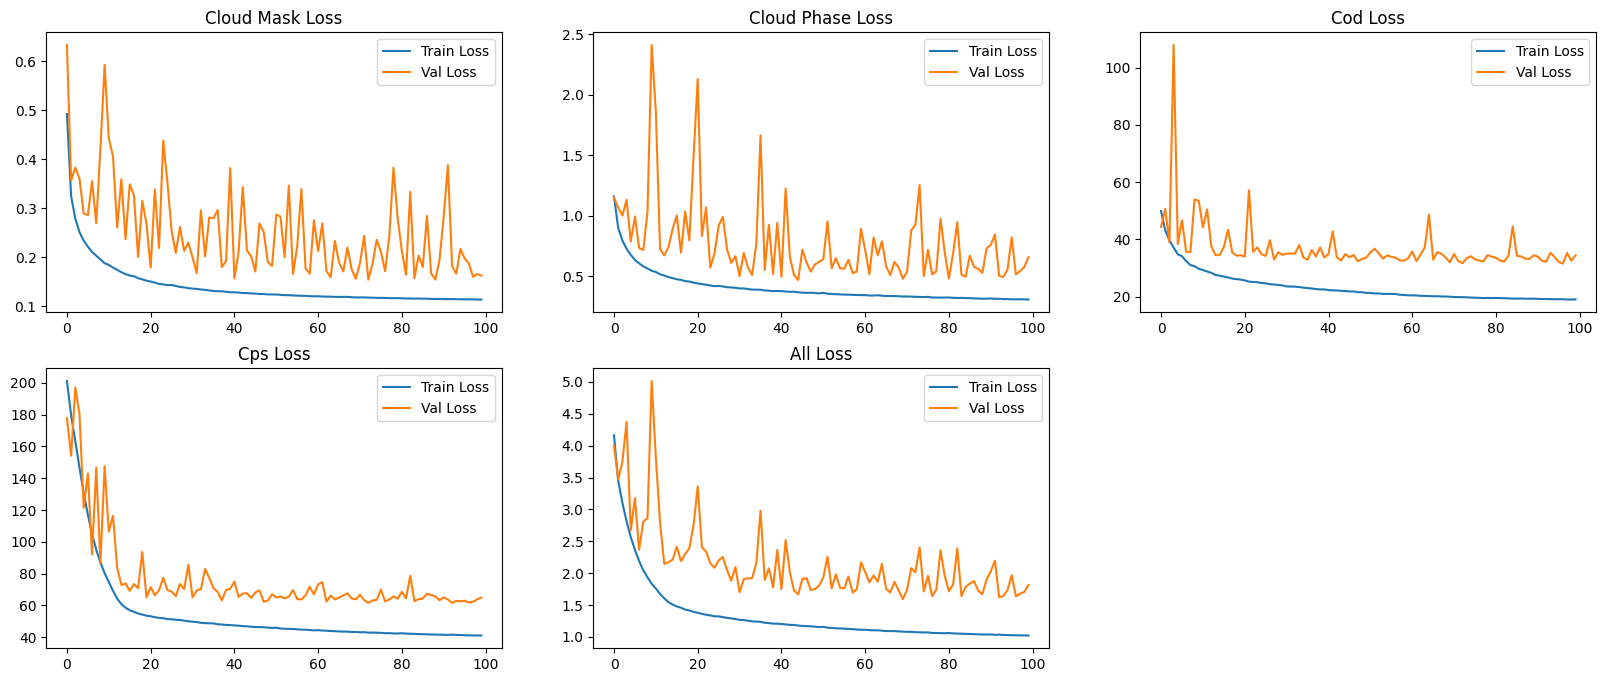

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV4_loss.png")  

plt.show()

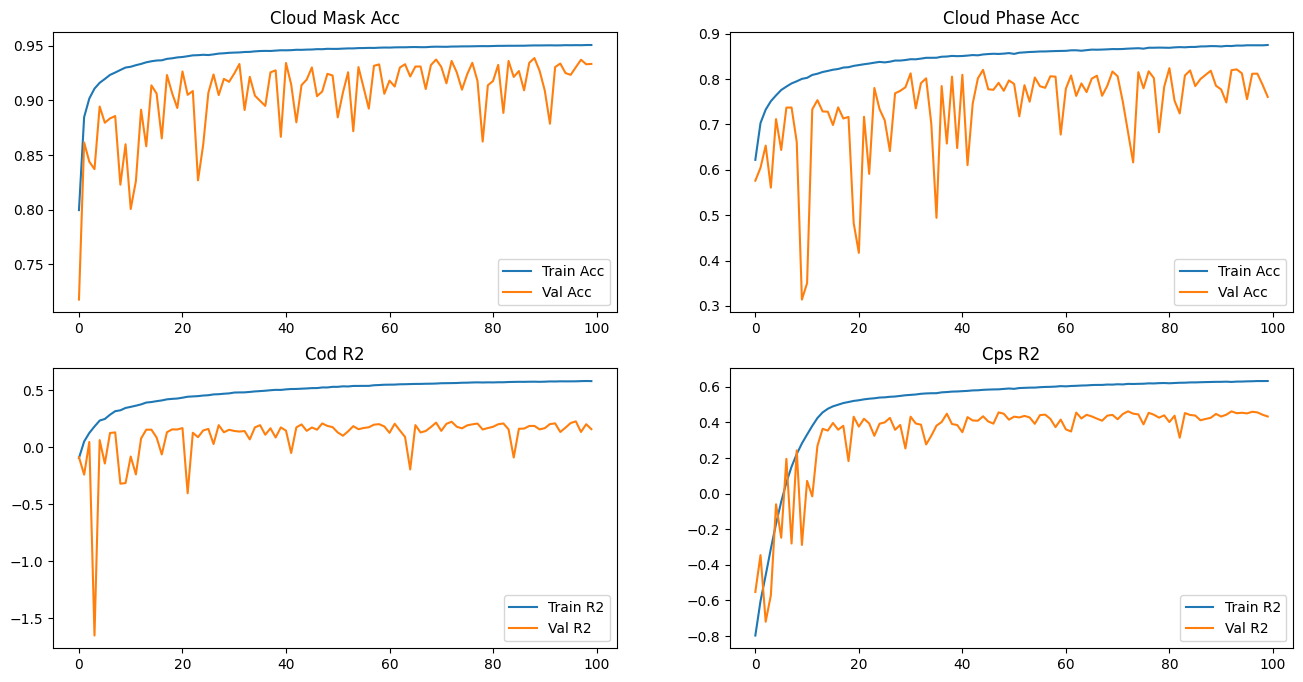

<Figure size 640x480 with 0 Axes>

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.show()

plt.savefig("./graphs/MultiTaskV4_acc.png")  

In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))

100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.836     0.871     0.853   5215774
           1      0.965     0.954     0.959  19360226

    accuracy                          0.936  24576000
   macro avg      0.900     0.912     0.906  24576000
weighted avg      0.937     0.936     0.937  24576000

CONFUSION MATRIX:
 [[ 4541316   674458]
 [  891066 18469160]]


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:02<00:00,  5.69it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.827     0.822     0.825   3935344
           1      0.868     0.794     0.829  10860241
           2      0.821     0.524     0.640   3638930
           3      0.223     0.368     0.278   1149024
           4      0.705     0.919     0.798   4992461

    accuracy                          0.764  24576000
   macro avg      0.689     0.685     0.674  24576000
weighted avg      0.791     0.764     0.768  24576000

CONFUSION MATRIX:
 [[3234966  600863    1332    2113   96070]
 [ 574616 8623697  376992  330500  954436]
 [  23047  338864 1906426 1073938  296655]
 [   3686  116070   31334  422840  575094]
 [  75072  258892    6108   66093 4586296]]

IOU: [0.70145942 0.70831594 0.4701773  0.16128663 0.663266  ]
Unweighted IoU: 0.5409010568513534
Weighted IoU: 0.6372298193304581


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.82it/s]


r2: 0.15399372577667236
MSE: 42.3964958190918


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:02<00:00,  5.86it/s]


r2: 0.4221077561378479
MSE: 65.09203338623047
